반드시 들어가야 하는 내용 

지역에 따라서 선호하는 게임 장르가 다를까 라는 질문에 대답을 하셔야합니다.

연도별 게임의 트렌드가 있을까 라는 질문에 대답을 하셔야합니다.

출고량이 높은 게임에 대한 분석 및 시각화 프로세스가 포함되어야 합니다.

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'sudo apt autoremove' to remove it.
The following NEW packages will be installed:
  fonts-nanum
0 upgraded, 1 newly installed, 0 to remove and 34 not upgraded.
Need to get 9,604 kB of archives.
After this operation, 29.5 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 fonts-nanum all 20170925-1 [9,604 kB]
Fetched 9,604 kB in 3s (3,419 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 76, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletyp

In [47]:
from matplotlib import pyplot as plt
%matplotlib inline

# unicode minus를 사용하지 않기 위한 설정 (minus 깨짐현상 방지)
plt.rcParams['axes.unicode_minus'] = False
plt.rc('font', family='NanumBarunGothic')

In [5]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans 
from sklearn.preprocessing import StandardScaler 
import seaborn as sns 
from scipy import stats

# df
df = pd.read_csv('/content/drive/MyDrive/DS Project /vgames2.csv').drop(columns='Unnamed: 0',axis=1)

#EDA 
#장르의 결측치를 장르의 최빈값으로 채움 (Action)
df['Genre'].unique()
top_freq_genre = df['Genre'].describe().mode
df['Genre'] = df['Genre'].fillna('Action')

#publisher 결측치 최빈값으로
df['Publisher'] = df['Publisher'].fillna('Electronic Arts')

#na 값 시원하게드뢉해.........
df.dropna(inplace=True,axis=0)

In [6]:
#형변환,data cleansing 
def cleansing(item):
  if item == '0K':
    return 0
  if item == '0M':
    return 0
  if 'K' in item:
    return float(item.replace('K',''))*1000
  if 'M' in item:
    return float(item.replace('M',''))*1000000
  else:
    return float(item)*1000000

country_lst = ['NA_Sales','EU_Sales', 'JP_Sales', 'Other_Sales']

for country in country_lst:
   df[country] = df[country].apply(cleansing)
   df[country] = df[country].astype(int)

세 지역 별 장르에 따른 평균의 유의미한 차이가 있다


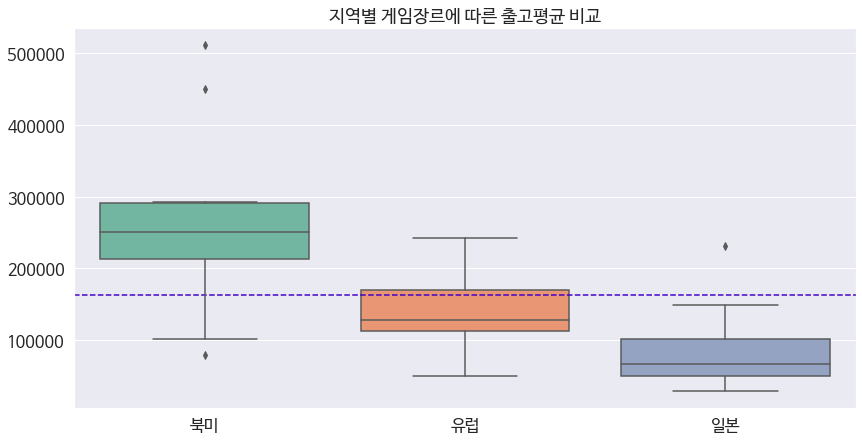

In [45]:
#1.지역 
#지역별 장르에따른 매출액의 평균 차이 가 있나?

#세 지역 별 장르에 따른 평균의 차이 -> two sample이상이므로, ANOVA 분산분석! 
#H0: 세 지역 별 장르에 따른 평균의 차이가 없다 (세 지역 모두 장르에따른 평균 매출액이 같다)
#H1: 세 지역 별 장르에 따른 평균의 유의미한 차이가 없다고 보기 힘들다 (세 지역 중 적어도 한 지역은 장르별 평균 매출액이 다르다)
#결론: p value가 유의미하게 나왔다, 대립가설 채택: 세 지여 중 적어도 한 지역은 장르별 평균 매출액이 다르다 (북미 지역이 두 지역과 분포가 다른것으로 추정...)

#1. NA
mean_NA = df.groupby('Genre').mean().iloc[:,1:4]['NA_Sales'].to_list()
#2. EU
mean_EU = df.groupby('Genre').mean().iloc[:,1:4]['EU_Sales'].to_list()
#e. JP
mean_JP = df.groupby('Genre').mean().iloc[:,1:4]['JP_Sales'].to_list()

fstat, pvalue_anova = stats.f_oneway(mean_NA,mean_EU,mean_JP)
print('세 지역 별 장르에 따른 평균의 유의미한 차이가 있다') if pvalue_anova<0.05 else print('세 지역 별 장르에 따른 평균의 차이가 없다 ')

#구체적 장르 선호확인 Top3 
# NA지역: df.groupby('Genre').sum()['NA_Sales'].sort_values(ascending=False)// Action->Sport->Shooter순 선호 
# EU지역: df.groupby('Genre')['EU_Sales'].sum().sort_values(ascending=False)//  Action->Sport->Shooter순 선호 
# JP지역: df.groupby('Genre').sum()['JP_Sales'].sort_values(ascending=False)//  Roleplaying->Action->Sports순 선호 


#총 평균 계산
num_meanNA = round(df.groupby('Genre')['NA_Sales'].mean().mean(),1)
num_meanEU = round(df.groupby('Genre')['EU_Sales'].mean().mean(),1)
num_meanJP = round(df.groupby('Genre')['JP_Sales'].mean().mean(),1)
total_mean_continent = (num_meanNA + num_meanEU + num_meanJP)/3

#시각화
#그래프 설명: 
#NA: 세 지역 중 가장 높은 매출액과 다른 두 집단에 비해 약 두배 이상의 큰 데이터의 분포양상을 띄고 있다.(매출액의 크기가 그만큼 다양하다는 뜻) 
#왼쪽에서 보이는 초록색 박스 안의 중간에 위치한 까만선은 North America지역 매출액의 중앙 값을 이야기하며 이는 대략 25만이다.

#EU: 평균적으로 봤을 때 세 지역 중 두번째로 높은 매출액을 보이며 (대략 13만) NA의 데이터 중앙 값인 25만과 비교해 봤을때
#약 11-12만의 차이를 보인다. 즉, North America지역의 평균 매출액은 EU 평균 매출액의 약 1.5배 이상이라고 볼 수 있다.  
#EU매출액의 범위는 보통 11만2천에서 17만 에 분포하는 양상을 띄며 이는 세 집단 중 두번째로 크다. 

#JP: 일본은 세 지역 중 평균적으로 가장 낮은 매출액을 보이며 (대략 7만), 매출액들도 평균에 집중되어있는 분포양상을 띄고 있다.
# 일본 매출액의 범위는 상대적으로 작은 5만 - 10만 이며, 세 지역의 평균선보다도 낮은 위치에 속해 있다.
fig, axes = plt.subplots()

axes.axhline(total_mean_continent, ls='--',color='#4000c7')
fig.set_size_inches(14,7)
sns.set(font_scale=1.5)
region_graph = sns.boxplot(data=df.groupby('Genre').mean().iloc[:,1:4],palette="Set2")
region_graph.set_xticklabels(labels=['북미','유럽','일본'])
plt.title("지역별 게임장르에 따른 출고평균 비교")
fig.savefig('ds_region1.png')

plt.show()

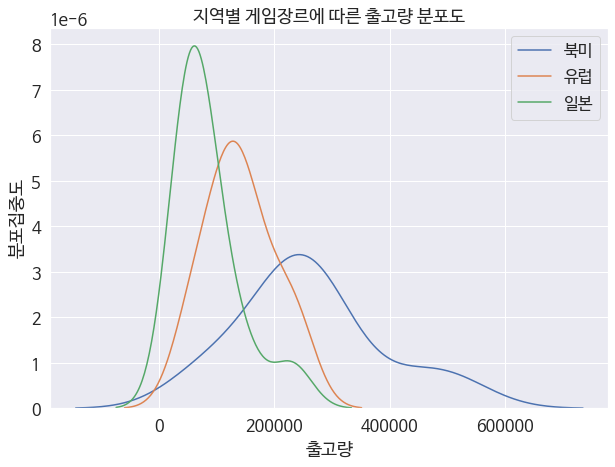

In [48]:
# 지역별 게임출고량평균 분포도 확인하기위한 kde plot 
plt.figure(figsize=(10,7))
sns.kdeplot(data=df.groupby('Genre')['NA_Sales'].mean(),label='북미')
sns.kdeplot(data=df.groupby('Genre')['EU_Sales'].mean(),label='유럽')
sns.kdeplot(data=df.groupby('Genre')['JP_Sales'].mean(),label='일본')

plt.title("지역별 게임장르에 따른 출고량 분포도")
plt.xlabel(xlabel='출고량')
plt.ylabel(ylabel='분포집중도')
plt.legend()

plt.savefig('anova_region.png')

plt.show()

9.799906785076602e-218


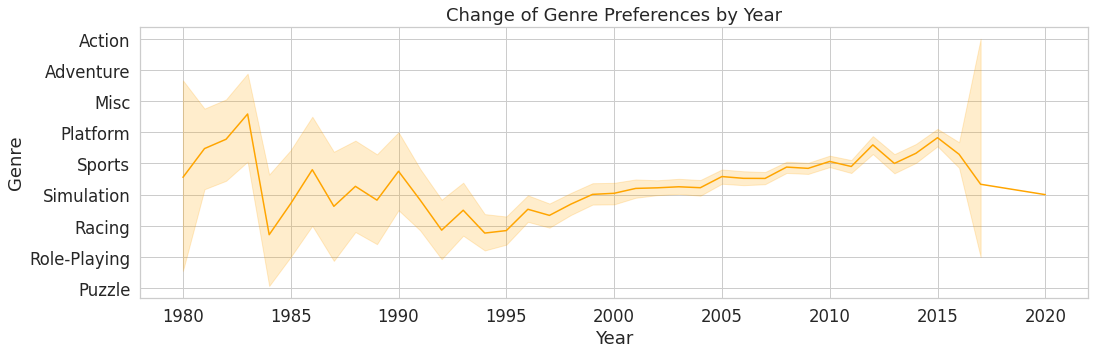

In [13]:
#2.연도 (연도별 장르 트렌드가 존재하는가?)
df['Year'] = df['Year'].astype(int)

#알수없는 연도값 제거 
df.drop(df[df.Year<1980].index,inplace=True)

#연도 범주화 및 Feature Engineering (Year항목에서 가져와서 4구간으로 카테고리화시킨 피쳐 만든다)
from scipy.stats import chisquare
from scipy.stats import chi2_contingency
from scipy import stats
df['Years_cut'] = pd.cut(df.Year,bins=[1980,1990,2000,2010,2020],labels=['80s','90s','20s','21s'])

# 가설설정
#H0: 연도와 게임 장르는 서로 영향을 미치지 않는다 
#H1: 연도와 게임 장르는 서로 영향을 미친다
#결론: p 값이 유의미하게 나오므로 연도와 게임 장르는 서로 영향을 미친다(연도가 달라지면 장르도 변화)
year_Gcrt = pd.crosstab(index=df['Years_cut'], columns=df['Genre'])
year_Genre_pval = stats.chi2_contingency(year_Gcrt)[1]
print(year_Genre_pval)

# 연도별 게임의 트렌드가 있을까 라는 질문에 대답을 하셔야합니다. 
# 주황색 라인 그래프가 그려져있는 세로 축 지점을 확인 해 보시면 
# -> 1980년도 초 : 장르 선호가 아직 구체화 되지않은 양상을 보입니다만, 주로 스포츠, 플랫폼, 그 외 다양한 넓은 범위의 장르들을 선호 하는 것으로 나타납니다.
#    1985년도 - 1995 년도: 트렌드가 바뀌면서 레이싱,시뮬레이션, 스포츠등을 주로 선호 하는 것으로 나타나고
#    1995년도 이후 - 2015년도: 에 들어서면서부터는 장르 선호가 범위가 더욱 좁아 지면서 시뮬레이션, 스포츠장르로 선호하는 게임 장르의 범위가 많이 좁혀집니다.
#    2015년도 - 2020년도: 스포츠 장르에서 시뮬레이션 장르로 선호도가 바뀌어 2020년에는 확실히 시뮬레이션 장르를 선호 하는 추세가 나타나있습니다. 

#시각화
fig = plt.figure(figsize=(17,5))
sns.lineplot(
    data=df,
    x="Year", y="Genre",color='orange',
)
fig.savefig('ds_year1.png')
sns.set_style('whitegrid')
plt.title("Change of Genre Preferences by Year")
plt.show()

In [42]:
#3.출고량 높은 게임 :Wii Sports
# 실제로 Wii sports의 평균 출고량이 세 지역의 개별 평균 출고량과 유의미하게 차이가 있나???? (Wii sports가 유의미하게 높다, 각 지열별 평균과 차이가 있다고 나온다는 가설) -> 1samp t-test를 시도했다.....

#EDA (각 지역별 출고량평균 상위 1위부터 20위까지 출력)
#1. NA: (Wii Sports : 1위)
df.groupby('Name')['NA_Sales'].mean().sort_values(ascending=False)[:20] 
#2. EU: (Wii Sports : 1위)
df.groupby('Name')['EU_Sales'].mean().sort_values(ascending=False)[:20] 
#3. JP: (Wii Sports : 20위)
df.groupby('Name')['JP_Sales'].mean().sort_values(ascending=False)[:20] 

# 1 sample t test 가설검정 
# H0: Wii sports의 평균은 모든 지역(세 지역:북미,유럽,일본)의 평균게임출고량과 같다
# H1: Wii sports의 평균은 모든 지역(세 지역:북미,유럽,일본)의 평균게임출고량과 같지않다 (차이가 있다)
# 결론: 세 지역 모두에서 p value가 0이나왔다.... 유의미하게 차이가 있다.
wii_mean_na = 41490000
wii_mean_eu = 29020000
wii_mean_jp = 3770000

tpv_na = stats.ttest_1samp(df.NA_Sales,41490000).pvalue
tpv_eu = stats.ttest_1samp(df.EU_Sales,29020000).pvalue
tpv_jp = stats.ttest_1samp(df.JP_Sales,3770000).pvalue

print(tpv_na)
print(tpv_eu)
print(tpv_jp)

#몇순위
#1. North America에서는 1순위
#1. EU에서도 1순위
#1. Japan에서는 상위 20위 

0.0
0.0
0.0


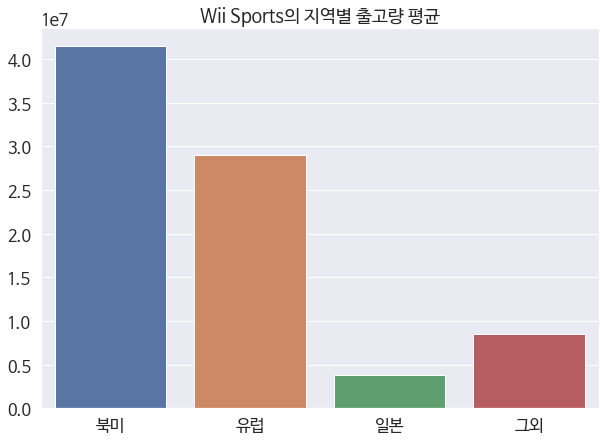

In [43]:
#시각화
plt.figure(figsize=(10,7))
g = sns.barplot(data=df.loc[df['Name'] == 'Wii Sports'].iloc[:,5:])
plt.title("Wii Sports의 지역별 출고량 평균")
g.set(xticklabels=['북미','유럽','일본','그외'])
plt.show()